COMPUTER EXERCISE 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, inv, norm, solve, matrix_rank
from scipy.io import loadmat
import cv2
from mpl_toolkits.mplot3d import Axes3D

def compute_camera_candidates(E):
    """
    Given an essential matrix E, compute the four possible (R, t) camera matrices.
    """
    # SVD of E
    U, S, Vt = np.linalg.svd(E)

    # Ensure det(UV^T) = +1
    if np.linalg.det(U @ Vt) < 0:
        U[:, -1] *= -1  # Flip sign of last column of U

    # Rotation matrices
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    # Translation is the third column of U
    u3 = U[:, 2]

    # Four possible (R, t) pairs
    candidates = [
        (U @ W @ Vt,  +u3),
        (U @ W @ Vt,  -u3),
        (U @ W.T @ Vt, +u3),
        (U @ W.T @ Vt, -u3)
    ]
    return candidates


In [47]:
def triangulate_point_dlt(P1, P2, x1, x2):
    """
    Triangulate a single 3D point given its 2D projections in two images.
    """
    A = np.array([
        x1[0] * P1[2] - x1[2] * P1[0],
        x1[1] * P1[2] - x1[2] * P1[1],
        x2[0] * P2[2] - x2[2] * P2[0],
        x2[1] * P2[2] - x2[2] * P2[1]
    ])

    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Last row of Vt is the solution
    return X / X[-1]  # Normalize (make last coordinate 1)
def select_best_camera(P1, candidates, x1, x2):
    best_P2 = None
    best_X = None
    max_in_front = -1

    for R, t in candidates:
        P2 = np.hstack((R, t.reshape(3, 1)))  # Construct camera matrix

        # Triangulate points
        X = np.array([triangulate_point_dlt(P1, P2, x1[:, i], x2[:, i]) for i in range(x1.shape[1])]).T

        # Convert to inhomogeneous coordinates
        X /= X[3, :]

        # Count points in front of both cameras
        count_front = np.sum(np.logical_and((P1 @ X)[2, :] > 0, (P2 @ X)[2, :] > 0))


        print(f"[DEBUG] Candidate P2:\n{P2}")
        print(f"[DEBUG] Points in front of both cameras: {count_front}")

        if count_front > max_in_front:
            max_in_front = count_front
            best_P2 = P2
            best_X = X

    print(f"[DEBUG] Best P2 (Normalized):\n{best_P2}")
    print(f"[DEBUG] Maximum points in front: {max_in_front}")

    return best_P2, best_X



def plot_reprojection_error2(P, x, X, img, text):
    """
    Plot the original 2D points and the reprojected 3D points on the image.
    """
    # Project 3D points onto the image
    x_reproj = P @ X
    x_reproj /= x_reproj[2, :]  # Convert to inhomogeneous (scale by third row)

    # Create figure BEFORE plotting the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')  # Display image as background

    # Plot original 2D points (actual feature matches)
    plt.scatter(x[0, :], x[1, :], color='blue', label='Original Points', s=5)

    # Plot reprojected 3D points onto 2D image
    plt.scatter(x_reproj[0, :], x_reproj[1, :], color='red', marker='x', label='Reprojected Points', s=1)

    # Set image bounds
    h, w, _ = img.shape
    plt.xlim([0, w])  # Image width
    plt.ylim([h, 0])  # Image height (flip y-axis for image coordinates)

    plt.title(f"Original vs. Projected 3D Points {text}")
    plt.legend()
    plt.show()


def plot_3d_scene2(X, P1, P2): # Not working as intended
    """
    Plot the 3D points and camera positions in a 3D space.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert homogeneous to inhomogeneous
    X = X[:3, :] / X[3, :]

    ax.scatter(X[0], X[1], X[2], marker='o', color='b', label="3D Points")

    # Compute camera centers
    C1 = np.array([0, 0, 0])  # Since P1 = [I | 0]
    R2 = P2[:, :3]
    t2 = P2[:, 3]
    t2 = t2 / np.linalg.norm(t2)  # Normalize translation
    C2 = -R2.T @ t2  # Camera center for P2

    ax.scatter(*C1, color='r', marker='^', label="Camera 1")
    ax.scatter(*C2, color='g', marker='^', label="Camera 2")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Reconstruction")
    ax.legend()
    plt.show()


[DEBUG] Candidate P2:
[[ 0.62208686  0.27002211  0.73491224  0.92229092]
 [ 0.28035671 -0.95323078  0.11292118  0.14220198]
 [ 0.73103218  0.13579079 -0.66869486  0.35938565]]
[DEBUG] Points in front of both cameras: 2008
[DEBUG] Candidate P2:
[[ 0.62208686  0.27002211  0.73491224 -0.92229092]
 [ 0.28035671 -0.95323078  0.11292118 -0.14220198]
 [ 0.73103218  0.13579079 -0.66869486 -0.35938565]]
[DEBUG] Points in front of both cameras: 0
[DEBUG] Candidate P2:
[[ 0.99438445  0.02933304  0.10168156  0.92229092]
 [-0.03112361  0.99938639  0.01606773  0.14220198]
 [-0.10114785 -0.01914219  0.99468723  0.35938565]]
[DEBUG] Points in front of both cameras: 0
[DEBUG] Candidate P2:
[[ 0.99438445  0.02933304  0.10168156 -0.92229092]
 [-0.03112361  0.99938639  0.01606773 -0.14220198]
 [-0.10114785 -0.01914219  0.99468723 -0.35938565]]
[DEBUG] Points in front of both cameras: 0
[DEBUG] Best P2 (Normalized):
[[ 0.62208686  0.27002211  0.73491224  0.92229092]
 [ 0.28035671 -0.95323078  0.11292118  0

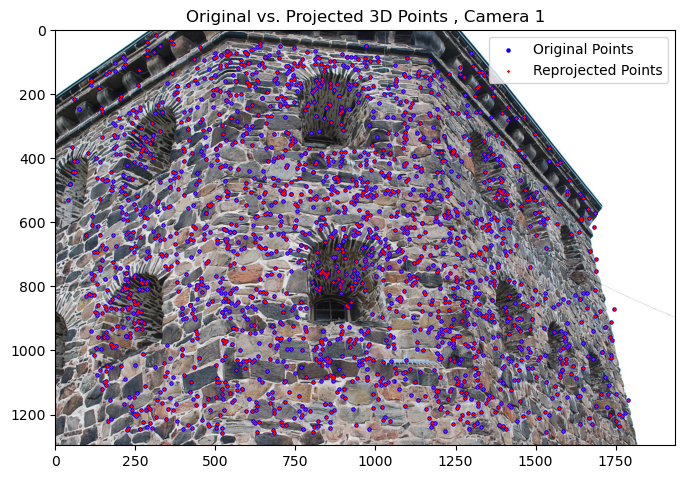

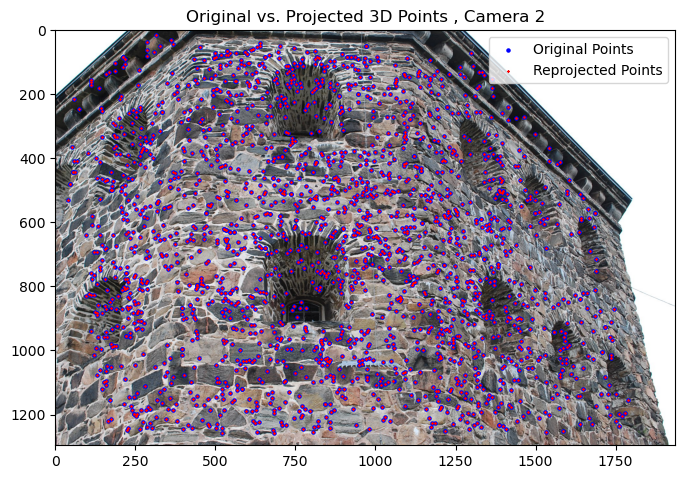

IndexError: index 3 is out of bounds for axis 0 with size 3

In [57]:
# Given essential matrix E
E = np.array([
    [-8.88845452, -1005.80666,  377.078254],
    [1252.52308,   78.367716, -2448.17426],
    [-472.788839,  2550.19170,    1.0]
])
data = loadmat('compEx3data.mat')
K = data['K']
data = loadmat('compEx1data.mat')
x = data['x']  
x1 = x[0, 0]  # First set of points (homogeneous 3×N)
x2 = x[1, 0]
# Load the image
image_filename = 'kronan1.jpg' # Change this to the other image when done
img = cv2.imread(image_filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P1 = K @ P1  # Convert to unnormalized coords
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # First camera at origin
P1 = K @ P1  # Convert to normalized coordinates



candidates = compute_camera_candidates(E)
best_P2, best_X = select_best_camera(P1, candidates, x1, x2)
import numpy as np
import plotly.graph_objects as go

def plot_3d_scene_interactive(X, P1, P2, scale_factor=1.0):
    # Convert homogeneous to inhomogeneous coordinates
    X = X[:3, :] / X[3, :]

    # Compute camera centers
    C1 = np.array([0, 0, 0])  # First camera at the origin
    R2, t2 = P2[:, :3], P2[:, 3]

    # Scale translation to avoid extreme distances
    C2 = -np.linalg.inv(R2) @ (t2 * scale_factor)  

    # Create scatter plot for 3D points
    scatter_points = go.Scatter3d(
        x=X[0], y=X[1], z=X[2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name="3D Points"
    )

    # Create scatter plot for camera positions
    scatter_cameras = go.Scatter3d(
        x=[C1[0], C2[0]],
        y=[C1[1], C2[1]],
        z=[C1[2], C2[2]],
        mode='markers',
        marker=dict(size=8, color=['red', 'green'], symbol='diamond'),
        name="Cameras"
    )

    # Create figure
    fig = go.Figure(data=[scatter_points, scatter_cameras])

    # Set axis labels
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        title="Interactive 3D Reconstruction",
    )

    fig.show()

    # Convert homogeneous to inhomogeneous coordinates
    X = X[:3, :] / X[3, :]

    # Compute camera centers
    C1 = np.array([0, 0, 0])  # First camera at the origin
    R2, t2 = P2[:, :3], P2[:, 3]
    C2 = -np.linalg.inv(R2) @ t2  # Compute the second camera center

    # Create scatter plot for 3D points
    scatter_points = go.Scatter3d(
        x=X[0], y=X[1], z=X[2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name="3D Points"
    )

    # Create scatter plot for camera positions
    scatter_cameras = go.Scatter3d(
        x=[C1[0], C2[0]],
        y=[C1[1], C2[1]],
        z=[C1[2], C2[2]],
        mode='markers',
        marker=dict(size=8, color=['red', 'green'], symbol='diamond'),
        name="Cameras"
    )

    # Create figure
    fig = go.Figure(data=[scatter_points, scatter_cameras])

    # Set axis labels
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        title="Interactive 3D Reconstruction",
    )

    fig.show()







if True:
    plot_reprojection_error2(P1, x1, best_X, img, ", Camera 1")
    # Load the image
    image_filename = 'kronan2.jpg' # Change this to the other image when done
    img = cv2.imread(image_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plot_reprojection_error2(P1, x1, best_X, img, ", Camera 2")

plot_3d_scene_interactive(best_X, P1, best_P2)


[DEBUG] Candidate P2:
[[ 0.62208686  0.27002211  0.73491224  0.92229092]
 [ 0.28035671 -0.95323078  0.11292118  0.14220198]
 [ 0.73103218  0.13579079 -0.66869486  0.35938565]]
[DEBUG] Points in front of both cameras: 2008
[DEBUG] Candidate P2:
[[ 0.62208686  0.27002211  0.73491224 -0.92229092]
 [ 0.28035671 -0.95323078  0.11292118 -0.14220198]
 [ 0.73103218  0.13579079 -0.66869486 -0.35938565]]
[DEBUG] Points in front of both cameras: 0
[DEBUG] Candidate P2:
[[ 0.99438445  0.02933304  0.10168156  0.92229092]
 [-0.03112361  0.99938639  0.01606773  0.14220198]
 [-0.10114785 -0.01914219  0.99468723  0.35938565]]
[DEBUG] Points in front of both cameras: 0
[DEBUG] Candidate P2:
[[ 0.99438445  0.02933304  0.10168156 -0.92229092]
 [-0.03112361  0.99938639  0.01606773 -0.14220198]
 [-0.10114785 -0.01914219  0.99468723 -0.35938565]]
[DEBUG] Points in front of both cameras: 0
[DEBUG] Best P2 (Normalized):
[[ 0.62208686  0.27002211  0.73491224  0.92229092]
 [ 0.28035671 -0.95323078  0.11292118  0

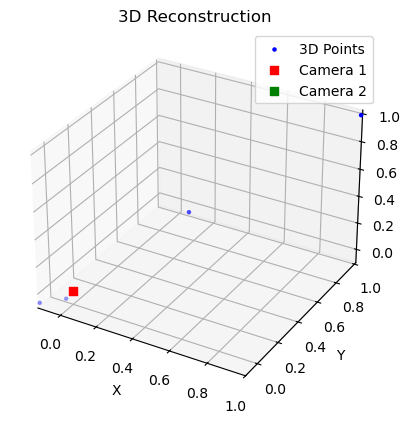

[DEBUG] Count in front: 2008
[DEBUG] Count in front: 0
[DEBUG] Count in front: 0
[DEBUG] Count in front: 0
[DEBUG] Normalized best_P2:
 [[ 1.73097301  0.75134359  2.04491256  2.56629867]
 [ 0.78009989 -2.65238964  0.31420615  0.39568075]
 [ 2.03411621  0.37784144 -1.86066097  1.        ]]


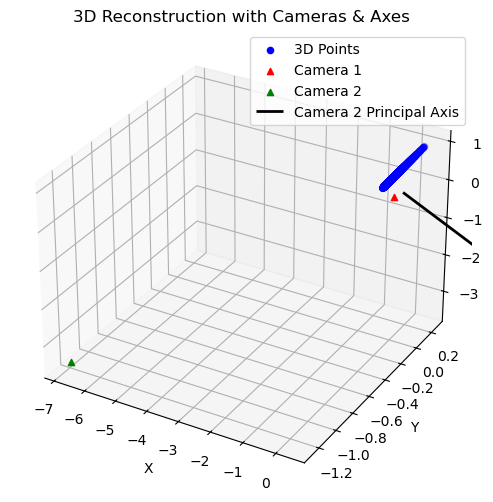

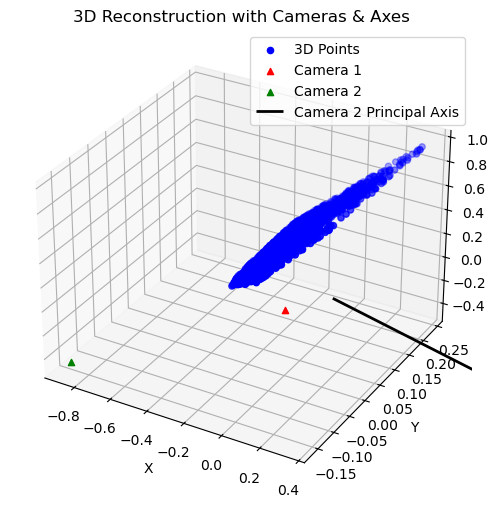

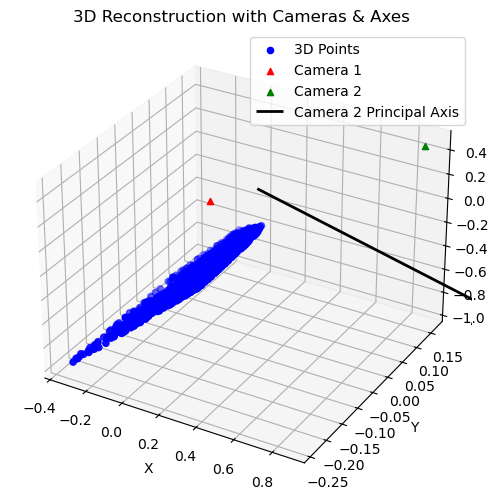

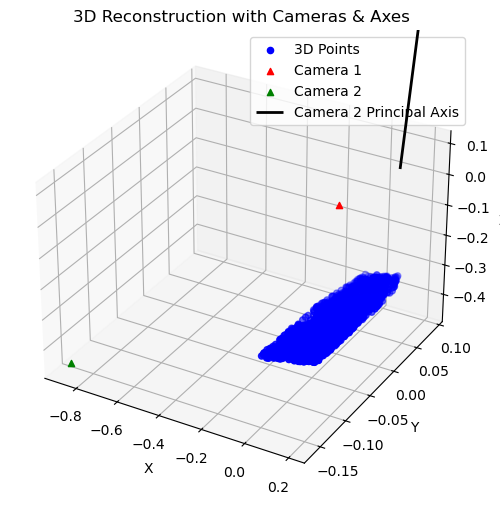

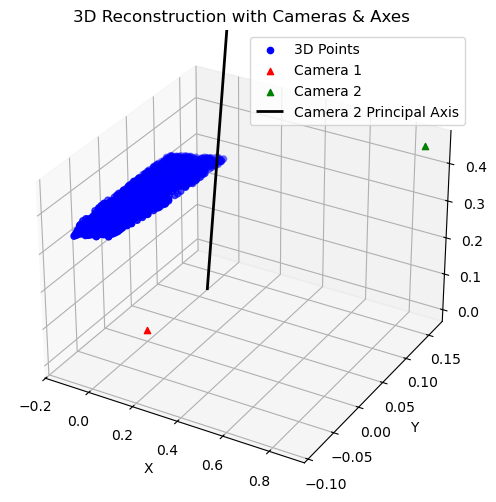

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import svd


def plot_3d_scene(X, P1, P2):
    """
    Plots 3D reconstructed points, camera positions, and principal axes.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Convert homogeneous to inhomogeneous coordinates
    X = X[:3, :] / X[3, :]
    ax.scatter(X[0], X[1], X[2], marker='o', color='b', label="3D Points")

    # Compute camera centers
    C1 = np.array([0, 0, 0])  # P1 assumed as [I|0]
    R2, t2 = P2[:, :3], P2[:, 3]
    C2 = -R2.T @ t2  # Camera 2 center

    ax.scatter(*C1, color='r', marker='^', label="Camera 1")
    ax.scatter(*C2, color='g', marker='^', label="Camera 2")
    # Draw only the principal axis for Camera 2 (Z-axis)
    scale_factor = 0.1
    C2 = scale_factor * C2/C2[2]
 
    ax.quiver(C2[0], C2[1], C2[2], 
            R2[0, 2], R2[1, 2], R2[2, 2], 
            color='k', length=2, linewidth=2, label="Camera 2 Principal Axis")



    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Reconstruction with Cameras & Axes")
    ax.legend()
    plt.show()
best_P2, best_X = select_best_camera(P1, candidates, x1, x2)
plot_3d_scene(best_X, P1, best_P2)
for R, t in candidates:
    P2 = np.hstack((R, t.reshape(3, 1)))

    # Triangulate points
    X = np.array([triangulate_point_dlt(P1, P2, x1[:, i], x2[:, i]) for i in range(x1.shape[1])]).T
    plot_3d_scene(X, P1, P2)